<a href="https://colab.research.google.com/github/erikycd/Heart_segmentation/blob/main/colab/UNET_pretrained_multiclass-Git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2 as cv

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import backend as K
import keras
print(keras.__version__)

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import layers, models, losses
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras import backend as K

print(tensorflow.__version__)

2.4.3
2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# READ DIRECTORIES

Path_images = '/content/drive/My Drive/Images/MICCAI MRI/MICCAI MRI/Imagenes/'
Path_mask_1 = '/content/drive/My Drive/Images/MICCAI MRI/MICCAI MRI/VI/'
Path_mask_2 = '/content/drive/My Drive/Images/MICCAI MRI/MICCAI MRI/VD/'

ids_images = sorted(os.listdir(Path_images))
ids_mask_1 = sorted(os.listdir(Path_mask_1))
ids_mask_2 = sorted(os.listdir(Path_mask_2))

print("Total of images :", len(ids_images))
print("Total of masks 1:", len(ids_mask_1))
print("Total of masks 2:", len(ids_mask_2))

Sample_image = cv.imread(Path_images + ids_images[0])
Sample_mask_1 = cv.imread(Path_mask_1 + ids_mask_1[0])
Sample_mask_2 = cv.imread(Path_mask_2 + ids_mask_2[0])

print('Sample image:',Sample_image.shape, Sample_image.min(), Sample_image.max(), 
      Sample_image.dtype)
print('Sample mask 1:',Sample_mask_1.shape, Sample_mask_1.min(), Sample_mask_1.max(),
      Sample_mask_1.dtype)
print('Sample mask 2:',Sample_mask_2.shape, Sample_mask_2.min(), Sample_mask_2.max(),
      Sample_mask_2.dtype)
print('Files images:',ids_images)
print('Files mask 1:',ids_mask_1)
print('Files mask 2:',ids_mask_2)


Total of images : 122
Total of masks 1: 122
Total of masks 2: 122
Sample image: (256, 256, 3) 0 255 uint8
Sample mask 1: (256, 256, 3) 0 255 uint8
Sample mask 2: (256, 256, 3) 0 255 uint8
Files images: ['(1).tiff', '(10).tiff', '(100).tiff', '(101).tiff', '(102).tiff', '(103).tiff', '(104).tiff', '(105).tiff', '(106).tiff', '(107).tiff', '(108).tiff', '(109).tiff', '(11).tiff', '(110).tiff', '(111).tiff', '(112).tiff', '(113).tiff', '(114).tiff', '(115).tiff', '(116).tiff', '(117).tiff', '(118).tiff', '(119).tiff', '(12).tiff', '(120).tiff', '(121).tiff', '(122).tiff', '(13).tiff', '(14).tiff', '(15).tiff', '(16).tiff', '(17).tiff', '(18).tiff', '(19).tiff', '(2).tiff', '(20).tiff', '(21).tiff', '(22).tiff', '(23).tiff', '(24).tiff', '(25).tiff', '(26).tiff', '(27).tiff', '(28).tiff', '(29).tiff', '(3).tiff', '(30).tiff', '(31).tiff', '(32).tiff', '(33).tiff', '(34).tiff', '(35).tiff', '(36).tiff', '(37).tiff', '(38).tiff', '(39).tiff', '(4).tiff', '(40).tiff', '(41).tiff', '(42).tiff'

In [4]:
# GENERATE MAIN TENSOR

im_width = Sample_image.shape[0]
im_height = Sample_image.shape[1]

X = np.zeros((len(ids_images), im_height, im_width, 3), dtype=np.float32)
y = np.zeros((len(ids_images), im_height, im_width, 1), dtype=np.float32)
z = np.zeros((len(ids_images), im_height, im_width, 1), dtype=np.float32)

# tqdm is used to display the progress bar
for n, id in tqdm_notebook(enumerate(zip(ids_images,ids_mask_1,ids_mask_2)),
                           total=len(ids_images) ):

    # Load image and intensity transformation [0,1]
    x_img = cv.imread(Path_images + id[0], cv.IMREAD_GRAYSCALE)
    x_img = img_to_array(x_img)
    x_img = resize(x_img, (im_width, im_height), mode = 'constant', preserve_range = True)
    x_img = (x_img - x_img.min())/(x_img.max() - x_img.min())
    x_img = np.repeat(x_img[:, :, :], 3, axis = 2)

    # Load masks 1
    mask_1 = cv.imread(Path_mask_1 + id[1], cv.IMREAD_GRAYSCALE)
    mask_1 = img_to_array(mask_1)
    mask_1 = resize(mask_1, (im_width, im_height), mode = 'constant', preserve_range = True)
    mask_1 = (mask_1/mask_1.max())
    mask_1 = 1.*( mask_1 > 0.5 ).astype(np.uint8)

    # Load masks 2))
    mask_2 = cv.imread(Path_mask_2 + id[2], cv.IMREAD_GRAYSCALE)
    mask_2 = img_to_array(mask_2)
    mask_2 = resize(mask_2, (im_width, im_height), mode = 'constant', preserve_range = True)
    mask_2 = mask_2/mask_2.max()
    mask_2 = 2.*( mask_2 > 0.5 ).astype(np.uint8)

    # Save images and masks
    X[n] = x_img
    Sum = mask_1 + mask_2
    Sum[Sum > 2] = 0
    y[n] = Sum

print('Tensor images:',X.shape,X.min(),X.max())
print('Tensor masks:',y.shape,y.min(),y.max())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



Tensor images: (122, 256, 256, 3) 0.0 1.0
Tensor masks: (122, 256, 256, 1) 0.0 2.0


In [5]:
# SPLIT MAIN TENSOR IN TRAIN, VALIDATION AND TEST

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.2, random_state=0)

print('Tensor X_train:',X_train.shape,X_train.min(),X_train.max())
print('Tensor y_train:',y_train.shape,y_train.min(),y_train.max())

print('Tensor X_valid:',X_valid.shape,X_valid.min(),X_valid.max())
print('Tensor y_valid:',y_valid.shape,y_valid.min(),y_valid.max())

print('Tensor X_test:',X_test.shape,X_test.min(),X_test.max())
print('Tensor y_test:',y_test.shape,y_test.min(),y_test.max())

Tensor X_train: (97, 256, 256, 3) 0.0 1.0
Tensor y_train: (97, 256, 256, 1) 0.0 2.0
Tensor X_valid: (20, 256, 256, 3) 0.0 1.0
Tensor y_valid: (20, 256, 256, 1) 0.0 2.0
Tensor X_test: (5, 256, 256, 3) 0.0 1.0
Tensor y_test: (5, 256, 256, 1) 0.0 2.0


Imagen 0:  (256, 256) float32 0.0 1.0
Both masks:  (256, 256) float32 0.0 2.0
Mask class 2:  (256, 256) bool False True
Mask class 2:  (256, 256) bool False True


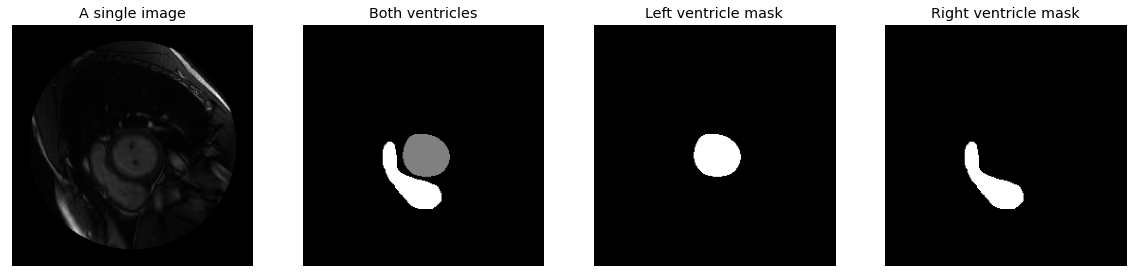

In [6]:
# VISUALIZATION OF A SINGLE IMAGE IN TRAIN TENSOR

plt.figure(figsize=(20,20))

label = 1
plt.subplot(1,4,1)
a = X_train[label,:,:,0]
print('Imagen 0: ',a.shape, a.dtype, a.min(), a.max())
plt.imshow(a, cmap='gray')
plt.title("A single image")
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,2)
b = y_train[label,:,:,0]
print('Both masks: ',b.shape, b.dtype, b.min(), b.max())
plt.imshow(b, cmap='gray')
plt.title("Both ventricles")
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,3)
c = y_train[label,:,:,0]==1
print('Mask class 2: ',c.shape, c.dtype, c.min(), c.max())
plt.imshow(c, cmap='gray')
plt.title("Left ventricle mask")
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,4)
d = y_train[label,:,:,0]==2
print('Mask class 2: ',d.shape, d.dtype, d.min(), d.max())
plt.imshow(d, cmap='gray')
plt.title("Right ventricle mask")
plt.xticks([])
plt.yticks([])

plt.show()

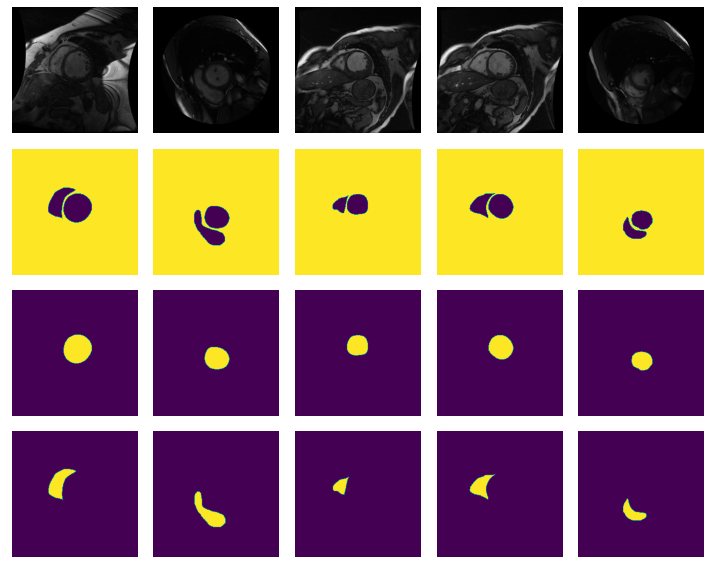

In [7]:
# VISUALIZATION OF TRAIN TENSOR

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=5):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap='gray')
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

y_train_categorical = to_categorical(y_train)
visualize(X_train[:], y_train_categorical[:])

In [8]:
# DEFINE FILTERS

def conv_block(input_tensor, num_filters):
  encoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same', depth_multiplier=1)(input_tensor)
  encoder = layers.BatchNormalization(axis=-1)(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.SpatialDropout2D(0.2)(encoder)
  encoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same', depth_multiplier=1)(encoder)
  encoder = layers.BatchNormalization(axis=-1)(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.SpatialDropout2D(0.2)(encoder)
  return encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor) #, kernel_initializer = keras.initializers.he_uniform())(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization(axis=-1)(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same', depth_multiplier=1)(decoder)

  decoder = layers.BatchNormalization(axis=-1)(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.SpatialDropout2D(0.2)(decoder)
  decoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same', depth_multiplier=1)(decoder)

  decoder = layers.BatchNormalization(axis=-1)(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.SpatialDropout2D(0.2)(decoder)
  return decoder

In [9]:
# LOAD PRETRAINED ARCHITECURE WITH WEIGHTS

Resnet = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet',  
                                                    input_shape=(256,256,3), pooling=None)

encoder0 = Resnet.layers[0].output 
encoder1 = Resnet.get_layer('conv1_conv').output 
encoder2 = Resnet.get_layer('conv2_block3_1_relu').output 
encoder3 = Resnet.get_layer('conv3_block4_1_relu').output 
encoder4 = Resnet.get_layer('conv4_block6_1_relu').output 
center = Resnet.layers[-1].output
for i in range( len(Resnet.layers) ):
  Resnet.layers[i].trainable = False

decoder4 = decoder_block(center, encoder4, 256)
decoder3 = decoder_block(decoder4, encoder3, 128)
decoder2 = decoder_block(decoder3, encoder2, 128)
decoder1 = decoder_block(decoder2, encoder1, 64)
decoder0 = decoder_block(decoder1, encoder0, 32)

outputs1 = layers.Conv2D(3, (1, 1), activation = 'softmax')(decoder0)

94674944/94668760 [==============================] - 4s 0us/step


In [10]:
# COMPILE MODEL AND DEFINE HYPERPARAMETERS

model = models.Model(inputs=[Resnet.input], outputs=[outputs1])

model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.005), 
              loss = losses.sparse_categorical_crossentropy, 
              metrics = ['sparse_categorical_accuracy'] )

In [11]:
# MODEL TRAINING

callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    ModelCheckpoint('model-Unet_multiclass_1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    epochs = 40, 
                    callbacks = callbacks,
                    validation_data = (X_valid, y_valid)
                    )

Epoch 1/40
25/25 [==============================] - 40s 219ms/step - loss: 0.9328 - sparse_categorical_accuracy: 0.6095 - val_loss: 0.6590 - val_sparse_categorical_accuracy: 0.9590

Epoch 00001: val_loss improved from inf to 0.65898, saving model to model-Unet_multiclass_1.h5
Epoch 2/40
25/25 [==============================] - 4s 149ms/step - loss: 0.1816 - sparse_categorical_accuracy: 0.9477 - val_loss: 0.3833 - val_sparse_categorical_accuracy: 0.9590

Epoch 00002: val_loss improved from 0.65898 to 0.38330, saving model to model-Unet_multiclass_1.h5
Epoch 3/40
25/25 [==============================] - 4s 147ms/step - loss: 0.1182 - sparse_categorical_accuracy: 0.9546 - val_loss: 0.2179 - val_sparse_categorical_accuracy: 0.9590

Epoch 00003: val_loss improved from 0.38330 to 0.21789, saving model to model-Unet_multiclass_1.h5
Epoch 4/40
25/25 [==============================] - 4s 148ms/step - loss: 0.0826 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.1152 - val_sparse_categorical_

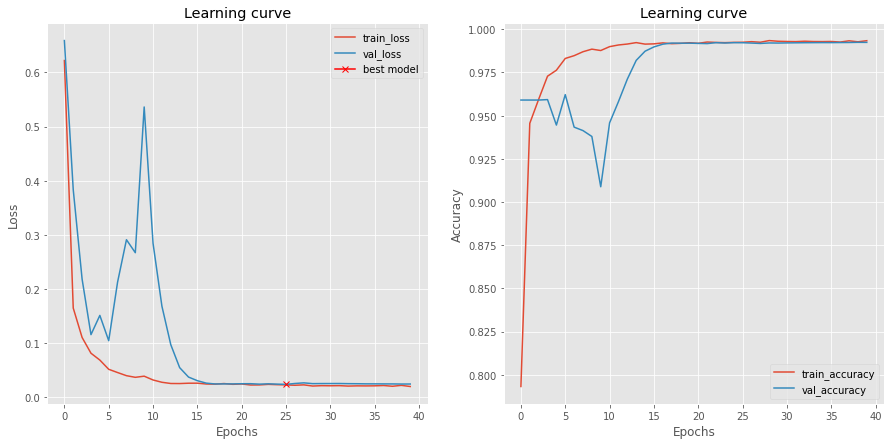

In [12]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.title("Learning curve")
plt.plot(results.history["loss"], label="train_loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

plt.subplot(1,2,2)
plt.title("Learning curve")
plt.plot(results.history['sparse_categorical_accuracy'], label='train_accuracy')
plt.plot(results.history['val_sparse_categorical_accuracy'], label= 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

In [13]:
# EVALUATE VALIDATION SET (Must be equals to the best Loss)

model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.0239 - sparse_categorical_accuracy: 0.9924


[0.023948438465595245, 0.9924033880233765]

In [14]:
# PREDICT TEST SET

predicted_label = model.predict(X_test)
print('Predicted label shape: ',predicted_label.shape, predicted_label.dtype, predicted_label.min(), predicted_label.max())
predicted_mask = to_categorical(np.argmax(predicted_label, -1), dtype='uint8')
print('Predicted mask shape: ',predicted_mask.shape, predicted_mask.dtype, predicted_mask.min(), predicted_mask.max())
print('y_test shape: ',y_test.shape, y_test.dtype, y_test.min(), y_test.max())

Predicted label shape:  (5, 256, 256, 3) float32 3.3955936e-09 0.99999917
Predicted mask shape:  (5, 256, 256, 3) uint8 0 1
y_test shape:  (5, 256, 256, 1) float32 0.0 2.0


In [15]:
# COMPUTING DICE METRIC ON PREDICTED SET

def dice_coeff(y_true, y_pred):

  Dice_class_1 = np.zeros(y_true.shape[0])
  Dice_class_2 = np.zeros(y_true.shape[0])

  for k in range(y_true.shape[0]):

    img1 = np.asarray(y_true[k,:,:,0]==1).astype(np.bool)
    img2 = np.asarray(y_pred[k,:,:,1]).astype(np.bool)
    if img1.sum() + img2.sum() == 0: return 1
    intersection = np.logical_and(img1, img2)
    Dice_class_1[k] = 2. * intersection.sum() / (img1.sum() + img2.sum())

    img3 = np.asarray(y_true[k,:,:,0]==2).astype(np.bool)
    img4 = np.asarray(y_pred[k,:,:,2]).astype(np.bool)
    if img3.sum() + img4.sum() == 0: return 1
    intersection = np.logical_and(img3, img4)
    Dice_class_2[k] = 2. * intersection.sum() / (img3.sum() + img4.sum())

  return Dice_class_1, Dice_class_2

Dice_class_1 , Dice_class_2 = dice_coeff(y_test,predicted_mask)

print('Shape of true labels:',y_test.shape,y_test.min(),y_test.max())
print('Shape of predicted labels:',predicted_mask.shape,predicted_mask.min(),predicted_mask.max())

print('Dice mean class 1:',Dice_class_1.mean())
print('Dice per image_class_1:',Dice_class_1)

print('Dice mean class 2:',Dice_class_2.mean())
print('Dice per image_class_2:',Dice_class_2)


Shape of true labels: (5, 256, 256, 1) 0.0 2.0
Shape of predicted labels: (5, 256, 256, 3) 0 1
Dice mean class 1: 0.9671317367636864
Dice per image_class_1: [0.96844248 0.98086957 0.97880093 0.93467337 0.97287234]
Dice mean class 2: 0.8888607654717893
Dice per image_class_2: [0.94348463 0.82895109 0.94192308 0.84641933 0.88352571]


Imagen:  (256, 256) float32 0.0 1.0
True mask:  (256, 256) float32 0.0 2.0
Predicted mask:  (256, 256) float64 0.0 2.0


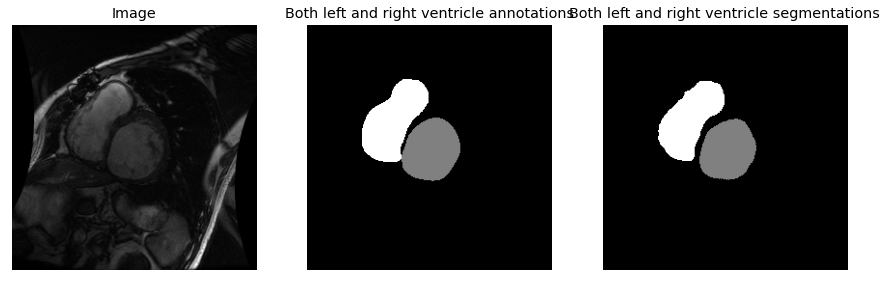

In [17]:
# COMPARISON OF A SINGLE IMAGE

plt.figure(figsize=(15,15))

label = 0
plt.subplot(1,3,1)
a = X_test[label,:,:,0]
print('Imagen: ',a.shape, a.dtype, a.min(), a.max())
plt.imshow(a, cmap='gray')
plt.title("Image")
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,2)
b = y_test[label,:,:,0]
print('True mask: ',b.shape, b.dtype, b.min(), b.max())
plt.imshow(b, cmap='gray')
plt.title("Both left and right ventricle annotations")
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3)
c = predicted_mask[label,:,:,1] + 2.*(predicted_mask[label,:,:,2])
print('Predicted mask: ',c.shape, c.dtype, c.min(), c.max())
plt.imshow(c, cmap='gray')
plt.title("Both left and right ventricle segmentations")
plt.xticks([])
plt.yticks([])

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text major ticklabel objects>)

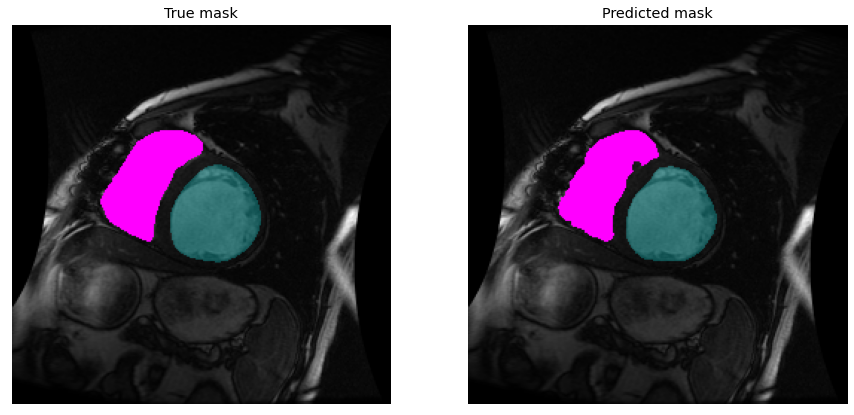

In [19]:
# OVERLAPED COLOR PLOT

def mask_color_img(img, mask_1, color_1, mask_2, color_2, alpha=0.3):
    '''
    img: cv2 image
    mask: bool or np.where
    color: BGR triplet [_, _, _]. Default: [0, 255, 255] is yellow.
    alpha: float [0, 1]. 

    Ref: http://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/
    '''
    out = img.copy()
    img_layer = img.copy()
    img_layer[mask_1] = color_1
    out = cv.addWeighted(img_layer, alpha, out, 1 - alpha, 0, out)

    out[mask_2] = color_2
    out2 = cv.addWeighted(out, alpha, out, 1 - alpha, 0, out)

    return out2


label = 2
a = X_test[label,:,:,0]
Image_rgb = np.repeat(a[:, :, np.newaxis], 3, axis=2)

true_class_1 = y_test[label,:,:,0]==1
true_class_2 = y_test[label,:,:,0]==2

True_mask = mask_color_img(Image_rgb,true_class_1,[0,255,255],
                           true_class_2,[100,0,200],alpha = 0.001)


predicted_class_1 = predicted_mask[label,:,:,1]==1
predicted_class_2 = predicted_mask[label,:,:,2]==1

Predicted_mask = mask_color_img(Image_rgb,predicted_class_1,[0,255,255],
                                predicted_class_2,[100,0,200],alpha = 0.001)


plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(True_mask)
plt.title("True mask")
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(Predicted_mask)
plt.title("Predicted mask")
plt.xticks([])
plt.yticks([])

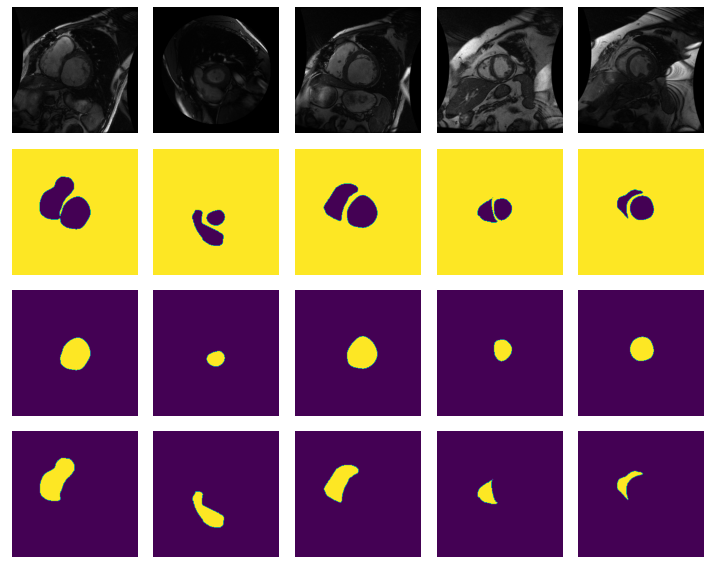

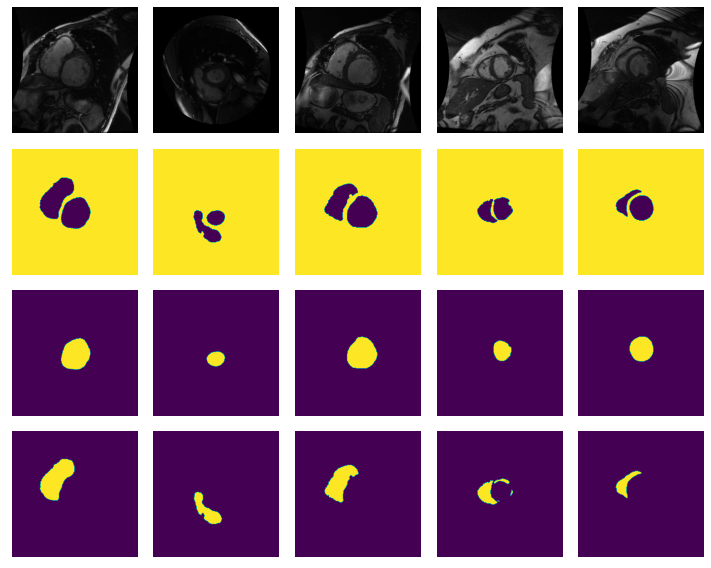

In [20]:
# VISUALIZATION OF PREDICTIONS OF TEST SET

y_test_categorical = to_categorical(y_test)
visualize(X_test, y_test_categorical)

visualize(X_test , predicted_mask)